# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [1]:
!wget https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw08_boosting_clustering/ds_salaries.csv

--2024-06-12 14:23:19--  https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw08_boosting_clustering/ds_salaries.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210076 (205K) [text/plain]
Saving to: ‘ds_salaries.csv’

ds_salaries.csv     100%[===================>] 205.15K  --.-KB/s    in 0.004s  

2024-06-12 14:23:19 (47.9 MB/s) - ‘ds_salaries.csv’ saved [210076/210076]



In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [3]:
from sklearn.model_selection import train_test_split

target = 'salary_in_usd'
columns_to_remove = ['salary', 'salary_currency']
df = df.drop(columns=columns_to_remove)

X = df.drop(columns=[target])
y = df[target]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (3004, 8), (3004,)
Validation set: (375, 8), (375,)
Test set: (376, 8), (376,)


## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_features = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
model.fit(X_train, y_train)
y_pred_val = model.predict(X_val)

mape = mean_absolute_percentage_error(y_val, y_pred_val)
rmse = mean_squared_error(y_val, y_pred_val, squared=False)

print('MAPE: ', mape)
print('RMSE: ', rmse)

MAPE:  0.4334691634895268
RMSE:  47983.06461259889


Прогнозы сильно ошибаются, что означает плохое качество (43% в случае MAPE и 47к долларов в случае RMSE)

## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [8]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import time

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
params = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 500],
    'gamma': [0, 0.1, 0.3, 0.5, 1],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1]
}

random_search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=50, cv=3, verbose=1, n_jobs=-1, random_state=42)
start_time = time.time()
random_search.fit(X_train_processed, y_train)
training_time = time.time() - start_time

best_model = random_search.best_estimator_
start_time = time.time()
y_pred_val = best_model.predict(X_val_processed)
prediction_time = time.time() - start_time

mape = mean_absolute_percentage_error(y_val, y_pred_val)
rmse = mean_squared_error(y_val, y_pred_val, squared=False)

print('Лучшие гиперпараметры: ', random_search.best_params_)
print('MAPE: ', mape)
print('RMSE: ', rmse)
print('Время обучения: ', training_time)
print('Время предсказания: ', prediction_time)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Лучшие гиперпараметры:  {'subsample': 1, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.5}
MAPE:  0.38325526579975316
RMSE:  45293.70456761146
Время обучения:  39.651644706726074
Время предсказания:  0.0038604736328125


Время предсказаний довольно быстрое, но вот точность предсказаний, хоть и чуть лучше, все равно довольно низкое

## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [10]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.0 MB/s eta 0:00:00


In [15]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(silent=True, random_seed=42))
])

params = {
    'model__depth': [3, 5, 7, 10],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__iterations': [100, 200, 500]
}
def neg_mape(y_true, y_pred):
    return -mean_absolute_percentage_error(y_true, y_pred)

grid_search = GridSearchCV(pipeline, param_grid=params, cv=3, scoring=make_scorer(neg_mape, greater_is_better=False))
start_time = time.time()
grid_search.fit(X_train, y_train)
training_time = time.time() - start_time

start_time = time.time()
y_pred_val = grid_search.predict(X_val)
prediction_time = time.time() - start_time

mape = mean_absolute_percentage_error(y_val, y_pred_val)
rmse = mean_squared_error(y_val, y_pred_val, squared=False)

print('Лучшие гиперпараметры: ', grid_search.best_params_)
print('MAPE: ', mape)
print('RMSE: ', rmse)
print('Время обучения: ', training_time)
print('Время предсказания: ', prediction_time)

Лучшие гиперпараметры:  {'model__depth': 3, 'model__iterations': 100, 'model__learning_rate': 0.01}
MAPE:  0.6207220417567271
RMSE:  50858.94593868519
Время обучения:  80.37599158287048
Время предсказания:  0.008425474166870117


Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [20]:
from catboost import Pool

train_pool = Pool(X_train, y_train, cat_features=categorical_features)
val_pool = Pool(X_val, y_val, cat_features=categorical_features)

params = {
    'depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'iterations': [100, 200, 500]
}
def grid_search_catboost(train_pool, val_pool, params):
    best_mape = float('inf')
    best_model = None
    best_params = None

    for depth in params['depth']:
        for learning_rate in params['learning_rate']:
            for iterations in params['iterations']:
                model = CatBoostRegressor(
                    depth=depth,
                    learning_rate=learning_rate,
                    iterations=iterations,
                    silent=True,
                    random_seed=42
                )

                start_time = time.time()
                model.fit(train_pool)
                training_time = time.time() - start_time

                start_time = time.time()
                y_pred_val = model.predict(val_pool)
                prediction_time = time.time() - start_time

                mape = mean_absolute_percentage_error(y_val, y_pred_val)
                rmse = mean_squared_error(y_val, y_pred_val, squared=False)

                if mape < best_mape:
                    best_mape = mape
                    best_model = model
                    best_params = {
                        'depth': depth,
                        'learning_rate': learning_rate,
                        'iterations': iterations
                    }

    return best_model, best_params, training_time, prediction_time

best_model, best_params, training_time, prediction_time = grid_search_catboost(train_pool, val_pool, params)
y_pred_val = best_model.predict(val_pool)
mape = mean_absolute_percentage_error(y_val, y_pred_val)
rmse = mean_squared_error(y_val, y_pred_val, squared=False)

print('Лучшие гиперпараметры: ', best_params)
print('MAPE: ', mape)
print('RMSE: ', rmse)
print('Время обучения: ', training_time)
print('Время предсказания: ', prediction_time)

Лучшие гиперпараметры:  {'depth': 5, 'learning_rate': 0.2, 'iterations': 500}
MAPE:  0.412867128067748
RMSE:  46449.96843709947
Время обучения:  14.381743907928467
Время предсказания:  0.0028645992279052734


**Ответ:** Качество и время заметно улучшились

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [22]:
from lightgbm import LGBMRegressor

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(random_state=42))
])
params = {
    'regressor__max_depth': [3, 5, 7, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__n_estimators': [100, 200, 500],
    'regressor__num_leaves': [31, 50, 100],
    'regressor__min_child_samples': [20, 50, 100]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=params,
    cv=3,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
grid_search.fit(X_train, y_train)
training_time = time.time() - start_time
best_model = grid_search.best_estimator_
start_time = time.time()
y_pred_val = best_model.predict(X_val)
prediction_time = time.time() - start_time

mape = mean_absolute_percentage_error(y_val, y_pred_val)
rmse = mean_squared_error(y_val, y_pred_val, squared=False)

print('Лучшие гиперпараметры: ', grid_search.best_params_)
print('MAPE: ', mape)
print('RMSE: ', rmse)
print('Время обучения: ', training_time)
print('Время предсказания: ', prediction_time)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 37
[LightGBM] [Info] Start training from score 138055.989348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

**Ответ:** На основе проведенного анализа, лучшей моделью с точки зрения качества предсказаний (MAPE: 0.3833, RMSE: 45293.70) является XGBoost. Она также имеет приличное время обучения (39.65 секунд) и предсказания (0.0039 секунд). Модель CatBoost с использованием Pool показала наилучшее время обучения (14.38 секунд) и предсказания (0.0029 секунд), хотя качество предсказаний у нее немного хуже (MAPE: 0.4129, RMSE: 46449.97). LightGBM также продемонстрировала хорошее качество (MAPE: 0.4037, RMSE: 46686.17), но время обучения оказалось самым долгим (128.67 секунд), что делает ее менее предпочтительной при ограничениях по времени. Модель CatBoost без использования Pool показала худшее качество предсказаний (MAPE: 0.6207, RMSE: 50858.95). В итоге, XGBoost является наиболее предпочтительной моделью с точки зрения качества предсказаний, а CatBoost с Pool — с точки зрения скорости обучения и предсказания

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [23]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [24]:
ratings = ratings.transpose()

Выкиньте строку под названием `user`.

In [25]:
ratings = ratings.drop('user')
ratings

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
modest mouse,NaN,NaN,NaN,NaN,0.015935,NaN,NaN,NaN,NaN,0.030437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
群星,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agalloch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
meshuggah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [26]:
ratings = ratings.fillna(0)
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
spiritualized®,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.078598,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [27]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(ratings)
labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [28]:
from collections import Counter
cluster_sizes = Counter(labels)
print("Размеры кластеров:", cluster_sizes)

Размеры кластеров: Counter({0: 996, 2: 1, 1: 1, 4: 1, 3: 1})


**Ответ:** Класстеризация вышла не очень полезной, почти все исполнители принадлежат одному кластеру, это может происходить из за того, что данные имеют сложную структуру.

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [29]:
single_cluster_artists = [artist for artist, label in zip(ratings.index, labels) if cluster_sizes[label] == 1]
print("Исполнители в кластерах размера 1:", single_cluster_artists)

Исполнители в кластерах размера 1: ['the beatles', 'daft punk', 'morricone', '보아']


Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [30]:
artist_stats = ratings.apply(lambda x: [x.mean(), (x > 0).mean()], axis=1)
artist_stats.columns = ['mean_listen_share', 'user_share']
print(artist_stats.loc[single_cluster_artists])

the beatles      [0.01836897659205146, 0.3342]
daft punk        [0.004222227721374765, 0.108]
morricone      [0.0010067622166630532, 0.0132]
보아             [0.0014623432024076946, 0.0096]
dtype: object


**Ответ:** The Beatles выделяется, потому что у них значительно выше доля пользователей, которые их слушают

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [31]:
from sklearn.preprocessing import normalize

normalized_ratings = normalize(ratings, axis=1)
kmeans_normalized = KMeans(n_clusters=5, random_state=0)
kmeans_normalized.fit(normalized_ratings)
normalized_labels = kmeans_normalized.labels_
normalized_cluster_sizes = Counter(normalized_labels)
print("Размеры кластеров после нормализации:", normalized_cluster_sizes)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Размеры кластеров после нормализации: Counter({4: 342, 2: 227, 0: 210, 1: 132, 3: 89})


Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

**Ответ** нормализация убирает разницу в масштабе между пользователями, что позволяет алгоритму KMeans лучше улавливать различия и сходства между исполнителями

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [32]:
from scipy.spatial.distance import cosine


centroids = kmeans_normalized.cluster_centers_
top_artists_per_cluster = {}
for i, centroid in enumerate(centroids):
    distances = []
    for artist_index in range(normalized_ratings.shape[0]):
        distance = cosine(centroid, normalized_ratings[artist_index])
        distances.append((artist_index, distance))
    distances.sort(key=lambda x: x[1])
    top_10_artists = [ratings.index[artist_index] for artist_index, _ in distances[:10]]
    top_artists_per_cluster[i] = top_10_artists

for cluster_id, artists in top_artists_per_cluster.items():
    print(f"Кластер {cluster_id}: {artists}")

Кластер 0: ['sonic youth', 'the clash', 'the pixies', 'velvet underground', 'oy division', 'the ramones', 'the smiths', 'descendents', 'the misfits', 'fugazi']
Кластер 1: ['nas', 'a tribe called quest', 'jay-z', "the roots featuring d'angelo", 'kanye west', 'mos def', 'gangstarr', 'lupe the gorilla', 'de la soul', 'little brother']
Кластер 2: ['sufjan stevens', 'radiohead', 'the arcade fire', 'the shins', 'broken social scene', 'belle and sebastian', 'deathcab for cutie', 'of montreal', 'animal collective', 'spoon']
Кластер 3: ['fall out boy', 'saosin', 'chiodos', 'taking back sunday', 'brand new', 'all time low', 'underoath', 'cartel', 'new found glory', 'mayday parade']
Кластер 4: ['coldplay', 'maroon5', 'john mayer', '\u200clinkin park', 'the killers', 'kelly clarkson', 'nickelback', 'the beatles', 'red hot clili peppers', 'foo fighters']


**Ответ:** Кластер 0: Включает исполнителей альтернативного рока и панка
Кластер 1: Содержит хип-хоп исполнителей
Кластер 2: Включает инди и альтернативных исполнителей
Кластер 3: Состоит из поп-панк и эмо-групп
Кластер 4:  Этот кластер объединяет исполнителей, которые имеют широкую популярность

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

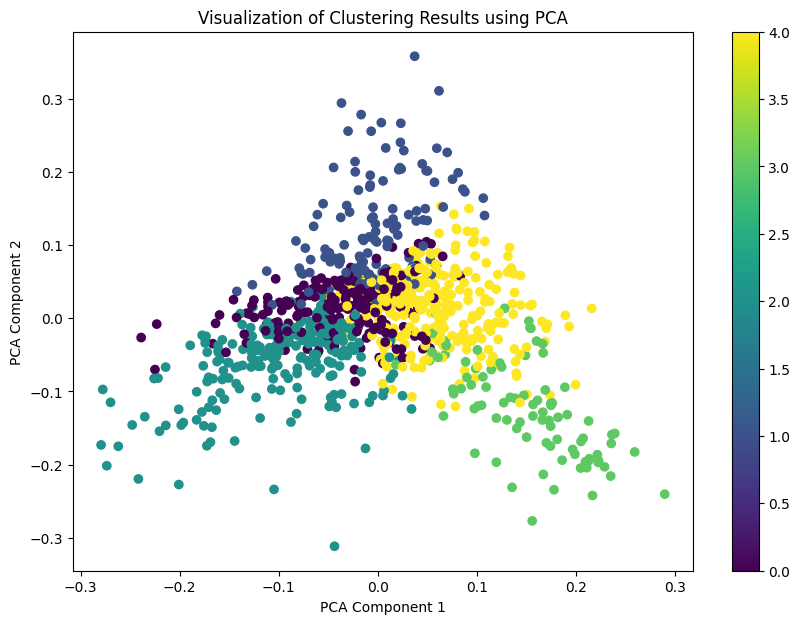

In [33]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
ratings_pca = pca.fit_transform(normalized_ratings)

plt.figure(figsize=(10, 7))
plt.scatter(ratings_pca[:, 0], ratings_pca[:, 1], c=normalized_labels, cmap='viridis', marker='o')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Visualization of Clustering Results using PCA')
plt.colorbar()
plt.show()


**Ответ:** Поскольку этот метод проецирует все на плоскость, часть объектов перемешалось и границы кластеров получились довольно размытыми

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

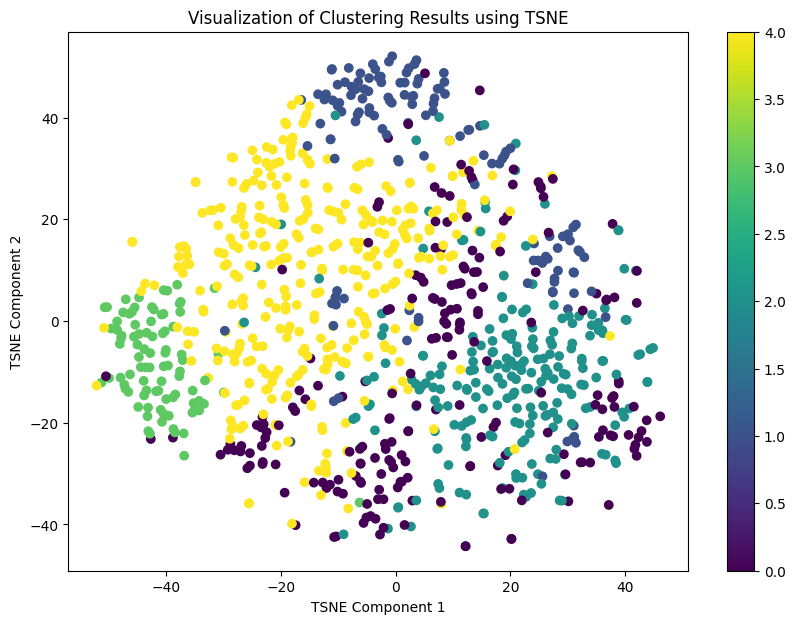

In [35]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
ratings_tsne = tsne.fit_transform(normalized_ratings)
plt.figure(figsize=(10, 7))
plt.scatter(ratings_tsne[:, 0], ratings_tsne[:, 1], c=normalized_labels, cmap='viridis', marker='o')

plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('Visualization of Clustering Results using TSNE')
plt.colorbar()
plt.show()

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [36]:
from sklearn.metrics import silhouette_score

max_clusters = 100
best_n_clusters = 2
best_silhouette = -1

for n_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(normalized_ratings)
    silhouette_avg = silhouette_score(normalized_ratings, cluster_labels)
    if silhouette_avg > best_silhouette:
        best_n_clusters = n_clusters
        best_silhouette = silhouette_avg

print(f"Оптимальное количество кластеров: {best_n_clusters}, Силуэт оценка: {best_silhouette}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Оптимальное количество кластеров: 95, Силуэт оценка: 0.015923489901689316


Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [37]:
kmeans_optimal = KMeans(n_clusters=best_n_clusters, random_state=42)
kmeans_optimal.fit(normalized_ratings)
optimal_labels = kmeans_optimal.labels_
optimal_centroids = kmeans_optimal.cluster_centers_
optimal_top_artists_per_cluster = {}
for i, centroid in enumerate(optimal_centroids):
    distances = []
    for artist_index in range(normalized_ratings.shape[0]):
        distance = cosine(centroid, normalized_ratings[artist_index])
        distances.append((artist_index, distance))
    distances.sort(key=lambda x: x[1])
    top_10_artists = [ratings.index[artist_index] for artist_index, _ in distances[:10]]
    optimal_top_artists_per_cluster[i] = top_10_artists

for cluster_id, artists in optimal_top_artists_per_cluster.items():
    print(f"Кластер {cluster_id}: {artists}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Кластер 0: ['circa survive', 'portugal. the man', 'cursive', 'citya and colour', 'the blood brothers', 'coheed and cambria', 'four year strong', 'owen', 'why?', 'manchester orchestra']
Кластер 1: ['the brian jonestown massacre', 'spiritualized®', 'black rebel motorcycle club', 'the dandy warhols', 'the verve', 'silver jews', 'pavement', 'the jesus and mary chain', 'velvet underground', 'sonic youth']
Кластер 2: ['squarepusher.', 'autechre', 'amon tobin', 'boards of canada', 'aphex twin', 'prefuse 73', 'underworld', 'rjd2', 'burial', 'björk guğmunsdóttir']
Кластер 3: ['talib kweli', "the roots featuring d'angelo", 'mos def', 'little brother', 'common', 'jurassic 5', 'cunninlynguists', 'lupe the gorilla', 'nas', 'a tribe called quest']
Кластер 4: ['mgmt', 'vampire weekend', 'tokyo police club', 'ratatat', 'kings of leon', 'the klaxons', 'justice', 'los campesinos!', 'the dodos', 'au rivoir simone']
Кластер 5: ['my bloody valentine', 'deerhunter', 'animal collective', 'slowdive', 'beach h

**Ответ:**Кластеры в основном сохранили свой первоначальный смысл, но стали более четкими и сфокусированными
Например, 17 кластер: ['miles davis.', 'john coltrane', 'thelonious monk', 'mingus charles', 'charlie parker', 'bill evans.', 'herbie hancock', 'scott jill', 'erykah badu', 'al green'] - Легенды джаза и исполнители соула.
39 кластер: ['the arcade fire', 'radiohead', 'sufjan stevens', 'the shins', 'spoon', 'of montreal', 'modest mouse', 'beirut', 'tv on the radio', 'interpol'] - инди рок и альтернативный рок.

Сделайте t-SNE визуализацию полученной кластеризации.

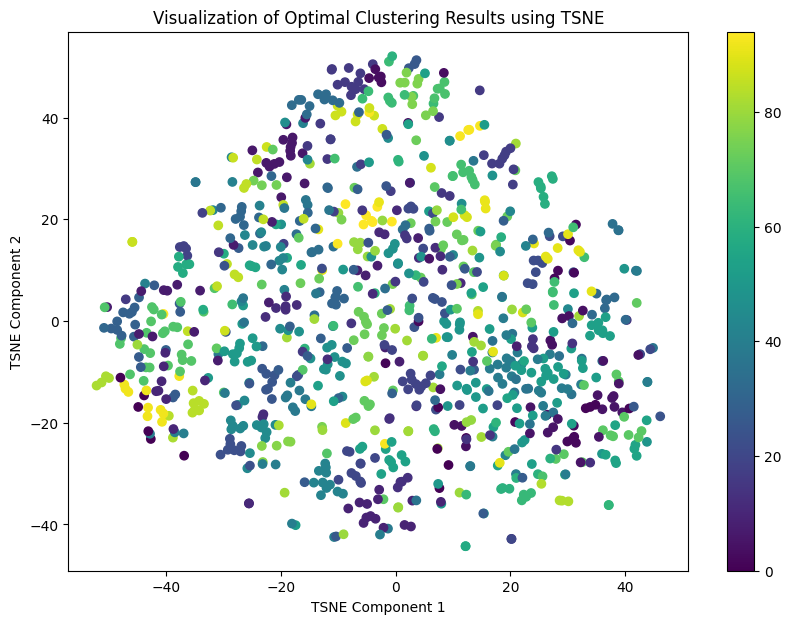

In [38]:
ratings_tsne_optimal = tsne.fit_transform(normalized_ratings)

plt.figure(figsize=(10, 7))
plt.scatter(ratings_tsne_optimal[:, 0], ratings_tsne_optimal[:, 1], c=optimal_labels, cmap='viridis', marker='o')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('Visualization of Optimal Clustering Results using TSNE')
plt.colorbar()
plt.show()

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

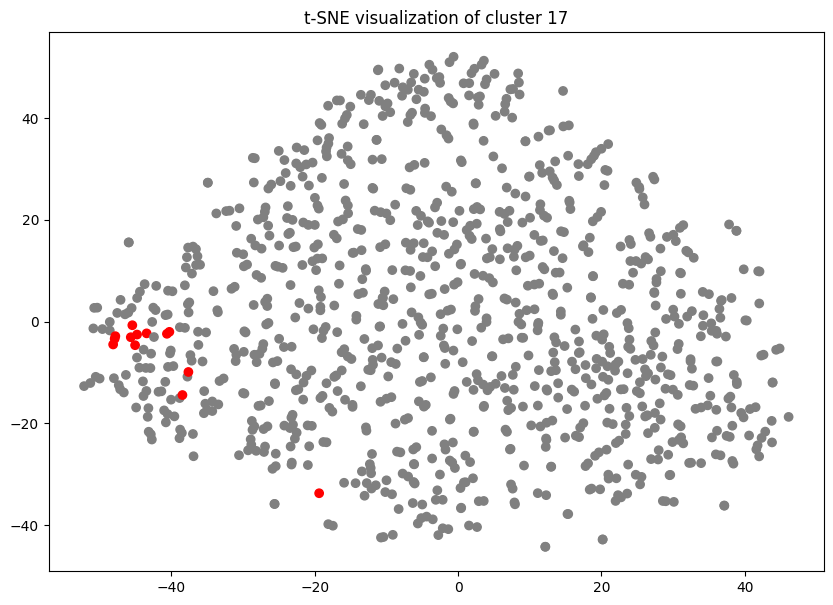

In [40]:
interesting_cluster = 17
colors = np.where(cluster_labels == interesting_cluster, 'red', 'gray')
plt.figure(figsize=(10, 7))
plt.scatter(ratings_tsne[:, 0], ratings_tsne[:, 1], c=colors)
plt.title(f't-SNE visualization of cluster {interesting_cluster}')
plt.show()

**Ответ:** 17 кластер отображается довольно хорошо